env: MKL_NUM_THREADS=2
env: THEANO_FLAGS=device=cpu, floatX=float32


Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 93,169
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_offset, e_var, g22, g11, g21, g_var, f_gp_geo_rotated_, geo_var, geo_ls, fixed_b, b_shrinkage]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 40239 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8360359245775537, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


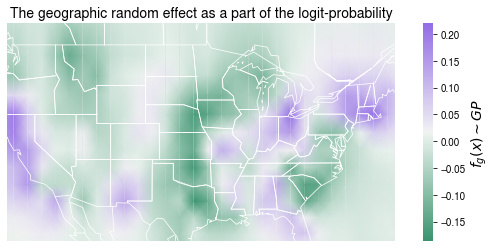

In [1]:
%env MKL_NUM_THREADS=2
%env THEANO_FLAGS=device=cpu, floatX=float32

import numpy as np
import pickle
import pymc3 as pm
import scipy.linalg
import theano.tensor as tt
import warnings
import sys

warnings.filterwarnings('ignore')

EPS = np.finfo(float).eps
NUM_CHAINS = 4

PHE_INDEX = 481

with open('../../../make phenotype 04142021/sample_phe.bpkl3', 'rb') as f:
    sample_phe = pickle.load(f)
    sample_phe_mat = sample_phe['sample_phe_mat']
    
OBS_Y = sample_phe_mat[:, PHE_INDEX]

with open('../../../data/sel_sample_model_variables2.bpkl3', 'rb') as f:
    var_dict = pickle.load(f)
    sex_age_fam21 = var_dict['fam21_demo']
    sex_age_fam11 = var_dict['fam11_demo']
    sex_age_fam22 = var_dict['fam22_demo']

TOTAL_SAMPLE_NUM = sample_phe_mat.shape[0]

NUM_FAM21 = sex_age_fam21.shape[0] // 3
NUM_FAM11 = sex_age_fam11.shape[0] // 2
NUM_FAM22 = sex_age_fam22.shape[0] // 4

BIAS_SEX_AGE = np.ones((TOTAL_SAMPLE_NUM, 3))
BIAS_SEX_AGE[:, 1:] = np.concatenate((sex_age_fam21, sex_age_fam11, sex_age_fam22))

with open('../../../data/sample_eqi_design_matrix.bpkl3', 'rb') as f:
    SAMPLE_EQI = pickle.load(f)
    SAMPLE_EQI_1 = SAMPLE_EQI[:, :5]
    
BIAS_SEX_AGE_EQI = np.hstack((BIAS_SEX_AGE, 
                              SAMPLE_EQI_1,
                              SAMPLE_EQI_1**2.0,
                              SAMPLE_EQI_1**3.0))


with open('../../../data/sample_geo.bpkl3', 'rb') as f:
    sample_geo = pickle.load(f)
    GEO_COORD_INDEX = sample_geo['all_member_geo_coord_index']
    GEO_COORD_COMB = sample_geo['geo_coord_comb']
    
    
# -----------------------------------------------------------------------------

# Make model

basic_model = pm.Model()
    
with basic_model:
    
    # Fixed effect: sex + age, shrinkage horseshoe prior
    b_shrinkage = pm.HalfCauchy('b_shrinkage', beta=1.0, shape=18)
    fixed_b = pm.Normal('fixed_b', mu=0, sigma=20.0*b_shrinkage, shape=18)
    
    # Fixed effect: geo coordinates
    geo_ls = pm.Gamma('geo_ls', alpha=2.0, beta=1.0)
    geo_var = pm.Gamma('geo_var', alpha=2.0, beta=1.0)
    geo_cov_func = geo_var * pm.gp.cov.ExpQuad(2, ls=geo_ls)
    geo_gp = pm.gp.Latent(cov_func=geo_cov_func)
    f_gp_geo = geo_gp.prior('f_gp_geo', X=GEO_COORD_COMB)
        
    # Random effect: genetic relationship
    g_var = pm.Gamma('g_var', alpha=2.0, beta=1.0)
    
    g21_mu = np.zeros(3)
    grm21 = np.array([[1.0, 0.0, 0.5], 
                      [0.0, 1.0, 0.5],
                      [0.5, 0.5, 1.0]]) 
    g21 = pm.MvNormal('g21', mu=g21_mu, cov=grm21, shape=(NUM_FAM21, 3))
    
    g11_mu = np.zeros(2)
    grm11 = np.array([[1.0, 0.5],
                      [0.5, 1.0]]) 
    g11 = pm.MvNormal('g11', mu=g11_mu, cov=grm11, shape=(NUM_FAM11, 2))
    
    g22_mu = np.zeros(4)
    grm22 = np.array([[1.0, 0.0, 0.5, 0.5], 
                      [0.0, 1.0, 0.5, 0.5],
                      [0.5, 0.5, 1.0, 0.5],
                      [0.5, 0.5, 0.5, 1.0]]) 
    g22 = pm.MvNormal('g22', mu=g22_mu, cov=grm22, shape=(NUM_FAM22, 4))
    
    g = tt.sqrt(g_var) * tt.concatenate([g21.flatten(), g11.flatten(), g22.flatten()])
    
    # Residuals
    e_var = pm.Gamma('e_var', alpha=2.0, beta=1.0)
    e_sd = tt.sqrt(e_var)
    e_offset = pm.Normal('e_offset', mu=0.0, sd=1.0, shape=TOTAL_SAMPLE_NUM)
    e = pm.Deterministic('e', e_offset*e_sd)
    
    # Additive model
    l = tt.dot(BIAS_SEX_AGE_EQI, fixed_b) + f_gp_geo[GEO_COORD_INDEX] + g + e
    y = pm.Bernoulli('y', logit_p=l, observed=OBS_Y)
    
        
with basic_model:
    start, step = pm.init_nuts(init='advi+adapt_diag', 
                               chains=NUM_CHAINS, 
                               n_init=200000,
                               target_accept=0.9)
    trace = pm.sample(draws=500,
                      chains=NUM_CHAINS,
                      tune=500,
                      start=start,
                      step=step,
                      discard_tuned_samples=True)
    
with open('tune500draw500/trace_{}.bpkl3'.format(PHE_INDEX), 'wb') as buff:
    pickle.dump({'model': basic_model, 
                 'trace': trace,
                 'step': step}, buff)
    

# -----------------------------------------------------------------------------

# Diagnoses and results

import seaborn as sb
import matplotlib.pyplot as plt
# plt.rc('font', family='Helvetica')
from pathlib import Path
import pandas as pd
import arviz as az

results_outpath = './results/cond_{}/'.format(PHE_INDEX)
Path(results_outpath).mkdir(parents=True, exist_ok=True)

# Trace plot
pm.traceplot(trace, ['g_var', 'e_var', 'geo_ls', 'geo_var',
                     'b_shrinkage', 'fixed_b'])
plt.savefig(results_outpath + 'trace_plot.pdf', format='pdf', bbox_inches='tight')
plt.close()

# Variable summary
var_summ = pm.summary(trace, ['g_var', 'e_var', 'geo_ls', 'geo_var',
                              'b_shrinkage', 'fixed_b'])
var_summ.to_csv(results_outpath + 'variable_summary.csv')

# Energy plot
energy = trace['energy']
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label='energy')
sb.distplot(energy_diff, label='energy diff')
plt.legend()
plt.savefig(results_outpath + 'energy_plot.pdf', format='pdf', bbox_inches='tight')
plt.close()

# Final results: h2, e2, WAIC
geo_var_trace = trace['geo_var']
g_var_trace = trace['g_var']
e_var_trace = trace['e_var']
total_var_trace = geo_var_trace + g_var_trace + e_var_trace

p2_trace = geo_var_trace / total_var_trace
h2_trace = g_var_trace / total_var_trace
e2_trace = e_var_trace / total_var_trace

p2_hpd = az.hdi(p2_trace, hdi_prob=0.95)
h2_hpd = az.hdi(h2_trace, hdi_prob=0.95)
e2_hpd = az.hdi(e2_trace, hdi_prob=0.95)

p2_mean = p2_trace.mean()
h2_mean = h2_trace.mean()
e2_mean = e2_trace.mean()

waic = pm.waic(trace, basic_model, scale='deviance')

key_results = pd.DataFrame(data={'p2 mean': [p2_mean],
                                 'p2 95% HPD lo': [p2_hpd[0]],
                                 'p2 95% HPD up': [p2_hpd[1]],
                                 
                                 'h2 mean': [h2_mean],
                                 'h2 95% HPD lo': [h2_hpd[0]],
                                 'h2 95% HPD up': [h2_hpd[1]],
                                 
                                 'e2 mean': [e2_mean],
                                 'e2 95% HPD lo': [e2_hpd[0]],
                                 'e2 95% HPD up': [e2_hpd[1]],
                                 
                                 'WAIC': [waic.waic],
                                 'pWAIC': [waic.p_waic]})
key_results.to_csv(results_outpath + 'key_results.csv')

# Geo plot
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib import font_manager as fm, rcParams
plt.rc('font', family='Nimbus Sans')
# font = fm.FontProperties(family='Helvetica', 
#                          fname='/home/hanxin/myFontTypes/Helvetica.ttf')
# import mpl_toolkits
# mpl_toolkits.__path__.append('/home/hanxin/.local/lib/python3.7/site-packages'
#                              '/basemap-1.2.1-py3.7-linux-x86_64.egg/mpl_toolkits')
from mpl_toolkits.basemap import Basemap
import seaborn as sns

f_gp_geo_est = trace['f_gp_geo'].mean(axis=0)
X = GEO_COORD_COMB[:,0]
Y = GEO_COORD_COMB[:,1]
X, Y = X.reshape((44, 24)), Y.reshape((44, 24))
Z = f_gp_geo_est.reshape((44, 24))

sels = np.where((X<-65) & (X>-135) & (Y>25) & (Y<55))

fig, ax = plt.subplots(figsize=(10, 4))
m = Basemap(projection='merc', resolution='c',
            llcrnrlon=-124, llcrnrlat=27,
            urcrnrlon=-68, urcrnrlat=51,
            # width=4.7E6, height=2.5E6, 
            lat_0=40, lon_0=-97,)
m.pcolormesh(X[sels[0],:][:,sels[1]],
             Y[sels[0],:][:,sels[1]],
             Z[sels[0],:][:,sels[1]],
             shading='gouraud',
             cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True),
             latlon=True)
m.drawstates(color='white', linewidth=.75)
m.drawcountries(color='white', linewidth=.75)
m.drawcoastlines(color='white', linewidth=.75)
ax.axis('off')
plt.title('The geographic random effect as a part of the logit-probability',
          fontsize=14)
cb = plt.colorbar()
cb.set_label(label=r'$f_g(x) \sim GP$', fontsize=14)
cb.outline.set_visible(False)
plt.savefig(results_outpath + 'geo_eff_plot.pdf')